In [1]:
import numpy as np

In [2]:
from sklearn.datasets import load_breast_cancer, load_iris
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from TreeStructures import TreeNode, ClassificationTree
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd
import sys
from tqdm.auto import tqdm
from time import sleep

In [3]:
def metric(data, labels):
    positives = data[labels==1]
    negatives = data[labels==0]
    
    m_p = np.mean(positives)
    m_n = np.mean(negatives)
    #print(np.mean(positives))
    #print(np.mean(negatives))
    #print(np.std(positives))
    #print(np.std(negatives))
    #print("fine")
    #print(np.exp(np.std(positives)*np.std(negatives)))
    #return np.abs((np.mean(positives)-np.mean(negatives))**2)+np.exp(-(np.std(positives)*np.std(negatives)))
    value = np.abs(m_p - m_n)**2/(np.std(positives)*np.std(negatives))
    if not np.isnan(value):
        return value
    else:
        return 0
    #return np.abs(m_p - m_n)**2
    

In [4]:
def get_best_split(X, y, data_idxs, rank):
    metrics = [metric(X[data_idxs, i], y[data_idxs]) for i in range(len(X[0,:]))]
    ranks = np.argsort(metrics)
    ranks = ranks[::-1]
    best_f = ranks[rank]
    best_m = metric(X[data_idxs, best_f], y[data_idxs])
    #print ("Best metric: ", best_m)
    indices = np.argsort(X[data_idxs, best_f])
    positive_r = np.count_nonzero(y[data_idxs])
    negative_r = len(data_idxs) - positive_r
    purity_right = np.abs(positive_r - negative_r)/len(indices)
    max_purity = purity_right
    n_p = 0
    n_n = 0
    best_x = None
    subset_X = X[data_idxs[indices], best_f]
    subset_y = y[data_idxs[indices]]
    i = 0
    n_left, n_right = 0, len(indices)
    while (i < len(subset_X)):
        
        if subset_y[i] == 0:
            n_n += 1
            negative_r -= 1
        else:
            n_p += 1
            positive_r -= 1
        
        
        k = 1
        while k+i < len(subset_X) and subset_X[k+i] == subset_X[i]:
            if subset_y[k+i] == 0:
                n_n += 1
                negative_r -= 1
            else:
                n_p += 1
                positive_r -= 1
            k+=1
            
        i+=k
        n_left += k
        n_right += -k
        #print(positive_r, negative_r)
        purity_right = np.abs(positive_r - negative_r)/(np.sqrt(len(subset_X)*(positive_r + negative_r)))
        purity_left = np.abs(n_p - n_n)/(np.sqrt(len(subset_X)*(n_p + n_n)))
        purity = purity_right + purity_left
        #print("Purity: ", purity)
        if purity > max_purity:
            max_purity = purity
            if (i+1 < len(subset_X)):
                best_x = (subset_X[i]+subset_X[i+1])*0.5
            else:
                best_x = None
    
    return best_f, best_x, max_purity
            
        
    

In [5]:
def get_best_split_purity(X, y, data_idxs):
    min_impur = np.inf
    best_f = None
    best_th = None
    alfa = 1
    #metrics = [metric(X[data_idxs, i], y[data_idxs]) for i in range(len(X[0,:]))]
    #ranks = np.argsort(metrics)
    #ranks = ranks[::-1]
    #feature = ranks[0]
    for feature in range(len(X[0])):
        indices = np.argsort(X[data_idxs, feature])
        subset_X = X[data_idxs[indices], feature]
        subset_y = y[data_idxs[indices]]
        #for i in range(len(subset_X)-1):
            #th = (subset_X[i]+subset_X[i+1])/2
            #points_left_indexes = [i for i in range(len(subset_X)) if subset_X[i] <= th]
            #points_right_indexes = [i for i in range(len(subset_X)) if subset_X[i] > th]

            #n_positive_left = np.count_nonzero(subset_y[points_left_indexes])
            #n_negative_left = len(points_left_indexes) - np.count_nonzero(subset_y[points_left_indexes])

            #n_positive_right = np.count_nonzero(subset_y[points_right_indexes])
            #n_negative_right = len(points_right_indexes) - np.count_nonzero(subset_y[points_right_indexes])
        i = 0
        n_left, n_right = 0, len(indices)
        n_positive_left = 0
        n_negative_left = 0
        n_positive_right = np.count_nonzero(subset_y)
        n_negative_right = n_right - n_positive_right

        while (i < len(subset_X) - 1):
            th = (subset_X[i]+subset_X[i+1])/2
            if subset_y[i] == 0:
                n_negative_left += 1
                n_negative_right -= 1
            else:
                n_positive_left += 1
                n_positive_right -= 1


            k = 1
            while k+i < len(subset_X) and subset_X[k+i] == subset_X[i]:
                if subset_y[k+i] == 0:
                    n_negative_left += 1
                    n_negative_right -= 1
                else:
                    n_positive_left += 1
                    n_positive_right -= 1
                k+=1

            i+=k
            n_left += k
            n_right += -k

            impurity_left = 1-np.abs(n_positive_left - n_negative_left)/len(subset_X)
            impurity_right = 1-np.abs(n_positive_right - n_negative_right)/len(subset_X)

            acc_mean = 1 - (np.abs(n_positive_left-n_negative_left)+np.abs(n_positive_right-n_negative_right))/len(subset_X)
            impurity = alfa*min(impurity_left, impurity_right) + (1-alfa)*acc_mean
            if impurity < min_impur:
                min_impur = impurity
                best_f = feature
                best_th = th
                
        
    return best_f, best_th, min_impur

In [6]:
class TAO:
    def __init__(self, tree, oblique = False, train_on_all_features = True):
        self.classification_tree = tree
        self.X = []
        self.y = []
        self.train_on_all_features = train_on_all_features

    def evolve(self, X, y, n_iter = 7, min_size_prune = 1):
        self.X = X
        self.y = y
        for i in range(n_iter):
            #print("TAO iter ", i, " di ", n_iter)
            for depth in reversed(range(self.classification_tree.depth + 1)):
                #print("Ottimizzo depth", depth, "....")
                T = self.classification_tree
                nodes = ClassificationTree.get_nodes_at_depth(depth, T)
                #print ([node.id for node in nodes])

                for node in nodes:
                    self.optimize_nodes(node)
                
                #Rimetto apposto i punti associati ad ogni nodo
                self.classification_tree.build_idxs_of_subtree(X, range(len(X)), T.tree[0], oblique = T.oblique)
        #ClassificationTree.restore_tree(self.classification_tree)
        self.prune()
        
    
    def optimize_nodes(self, node):
            #print ("node id = ", node.id, "depth = ", node.depth)
            #print("ottimizzo nodo: ", node.id)
            T = self.classification_tree
            X = self.X
            y = self.y
            if node.data_idxs:
                if node.is_leaf :
                    #Se il nodo è una foglia ottimizzo semplicemente settando la predizione
                    #alla classe più comune tra le instanze che arrivano a quella foglia
                    #print(max(node.data_idxs))
                    best_class = np.bincount(y[node.data_idxs]).argmax()
                    node.value = best_class
                    care_points_idxs = node.data_idxs
                    #print("Node value: ", node.value)
                    #print("Best class: ", best_class)
                else:
                    #In questo caso devo risolvere un problema di minimizzazione
                    #I punti da tenere in considerazione sono solo quelli tali che la
                    #predizione dei due figli del nodo corrente è diversa, e in almeno
                    #uno il punto viene classificato correttamente
                    care_points_idxs = []
                    correct_classification_tuples = {}
                    for data_idx in node.data_idxs:
                        left_label_predicted = T.predict_label(X[data_idx].reshape((1, -1)), node.left_node, T.oblique)
                        right_label_predicted = T.predict_label(X[data_idx].reshape((1, -1)), node.right_node, T.oblique)
                        correct_label = y[data_idx]
                        if (left_label_predicted != right_label_predicted and right_label_predicted==correct_label):
                            correct_classification_tuples[data_idx] = 1
                            care_points_idxs.append(data_idx)
                        elif (left_label_predicted != right_label_predicted and left_label_predicted==correct_label):
                            care_points_idxs.append(data_idx)
                            correct_classification_tuples[data_idx] = 0
                    self.TAO_best_split(node.id, X, y, care_points_idxs, correct_classification_tuples, T)
                    #print("care_points: ", care_points_idxs)

                #print ("indici nodo prima", node.id, "--->", node.data_idxs)
                #prec = node.data_idxs
                #print (set(prec) == set(node.data_idxs))


    def TAO_best_split(self, node_id, X, y, care_points_idxs, correct_classification_tuples, T):

        #Itero sulle componenti
        #print ("Ottimizzo nodo:", node_id)
        if len(care_points_idxs) > 1:
            #print(len(care_points_idxs))
            if T.oblique:
                best_t, best_weights = self.TAO_best_SVM_split(node_id, X, y, care_points_idxs, correct_classification_tuples, T)
                T.tree[node_id].intercept = best_t
                T.tree[node_id].weights = best_weights
            else:
                best_t, best_feature = self.TAO_best_parallel_split(node_id, X, y, care_points_idxs, correct_classification_tuples, T)
                #print("finale: ", error_best)
                T.tree[node_id].threshold = best_t
                T.tree[node_id].feature = best_feature


    #Qui faccio uno split parallelo agli assi
    def TAO_best_parallel_split(self, node_id, X, y, care_points_idxs, correct_classification_tuples, T):
        #print ("node id:", node_id)
        error_best = np.inf
        best_t = T.tree[node_id].threshold
        best_feature = T.tree[node_id].feature
        if self.train_on_all_features:
            features = range(len(X[0]))
        else:
            features = ClassificationTree.get_features(T)

        for j in features:
            #print(j)
            #Prendo tutte le j-esime componenti del dataset e le ordino
            #in modo crescente
            vals = {}
            for point_idx in care_points_idxs:
                vals[point_idx] = X[point_idx, j]

            values = sorted(vals.items(), key=lambda x: x[1])
            sorted_indexes = [tuple[0] for tuple in values]
            #plt.scatter(X[sorted_indexes, j], range(len(values)), s=0.4, c=list(correct_classification_tuples.values()))
            #plt.show()
            T.tree[node_id].feature = j
            thresh = 0.5*(X[sorted_indexes[0], j]+X[sorted_indexes[1], j])
            actual_loss, start = self.zero_one_loss(node_id, X, y, sorted_indexes, correct_classification_tuples, thresh, sorted_indexes)

            #if j==2:
                #base = actual_loss
            #actual_loss = self.binary_loss(node_id, X, y, sorted_indexes[i], correct_classification_tuples[sorted_indexes[i]], actual_loss, thresh)
            #print ("loss: ", actual_loss, "n punti: ", len(care_points_idxs))
            #print("vecchia: ", self.vecchia_loss(node_id, X, y, care_points_idxs, correct_classification_tuples, thresh))
            #Ciclo su ogni valore di quella componente e provo tutti gli split
            #possibili
            if actual_loss < error_best:
                error_best = actual_loss
                best_t = thresh
                best_feature = j
            i = start
            while i < len(sorted_indexes)-1:


                thresh = 0.5*(X[sorted_indexes[i], j]+X[sorted_indexes[i+1], j])

                #sum, k = self.binary_loss(X, j, sorted_indexes, i, correct_classification_tuples)
                #actual_loss += sum


                #Qualche print per debug
                '''
                if j==2 and node_id==3:
                    ones = [correct_classification_tuples[k] for k in sorted_indexes]
                    print("base: ", base, "  n punti:", len(sorted_indexes), "    loss:", actual_loss, "     thresh:", thresh, "     x:", X[sorted_indexes[i], j], "    prediction: ", correct_classification_tuples[sorted_indexes[i]])
                    print(X[sorted_indexes, j])
                    print()
                '''
                #actual_loss = self.zero_one_loss(node_id, X, y, care_points_idxs, correct_classification_tuples, thresh)

                s, k = self.binary_loss(X, j, sorted_indexes, i, correct_classification_tuples)
                #print ("dopo binary")
                actual_loss += s
                if actual_loss < error_best:
                    error_best = actual_loss
                    best_t = thresh
                    best_feature = j
                i+=k

            '''
            #print(error_best)
            #errors = [self.binary_loss(node_id, X, y, care_points_idxs, correct_classification_tuples, threshes[i]) for i in range(len(values)-1)]
            #min_index = np.argmin(errors)
        '''
        #Ancora print per debug
        #if node_id==1:
            #print("finale: ", error_best)
            #print ("ones:", ones, " len:  ", len(ones), "   care_p_len:", len(care_points_idxs))
            #print("best_feature:", best_feature, "   best_thresh:", best_t)



        return best_t, best_feature


    #Alla fine tolgo dead branches e pure subtrees
    def prune(self, min_size=1):
        #Prima controllo se ci sono sottoalberi puri.
        #Visito l'albero e verifico se esistono nodi branch ai quali arrivano punti associati a solo una label
        #Poi vedo se il nodo attuale è morto
        T = self.classification_tree
        stack = [T.tree[0]]
        while (stack):
            actual = stack.pop()
            if len(actual.data_idxs) > 0:
                #Se il nodo è puro
                if not actual.is_leaf and all(i == self.y[actual.data_idxs[0]] for i in self.y[actual.data_idxs]):
                    #Devo far diventare una foglia questo nodo con valore pari alla label
                    actual.is_leaf = True
                    actual.left_node = None
                    actual.right_node = None
                    actual.left_node_id = -1
                    actual.right_node_id = -1
                    actual.value = self.y[actual.data_idxs[0]]

                #Se il nodo ha un figlio morto devo sostituire il padre con l'altro figlio
                elif not actual.is_leaf and len(actual.left_node.data_idxs) < min_size:
                    stack.append(actual.right_node)
                    ClassificationTree.replace_node(actual, actual.right_node, T)
                elif not actual.is_leaf and len(actual.right_node.data_idxs) < min_size:
                    stack.append(actual.left_node)
                    ClassificationTree.replace_node(actual, actual.left_node, T)
                elif not actual.is_leaf:
                    stack.append(actual.right_node)
                    stack.append(actual.left_node)
            ClassificationTree.restore_tree(T)






    #Definico la loss base del nodo.
    #Significa che parto considerando come thresh la metà del minimo valore su quella componente.
    #Questo mi consente di evitare un O(n) e quindi
    #di ciclare su ogni punto del dataset per calcolare di nuovo la loss cambiando il
    #thresh. Ad ogni cambio, essendo i dati ordinati per componente la loss cambia
    #al più di una unità +/- 1. OCCORRE FARE ATTENZIONE A PUNTI UGUALI! VEDI BINARY LOSS
    def zero_one_loss(self, node_id, X, y, care_points_idxs, correct_classification_tuples, thresh, sorted_indexes):
        loss = 0
        T = self.classification_tree.tree
        node = T[node_id]
        #Per ogni punto del nodo verifico dove questo lo inoltrerebbe
        #se il punto viene inoltrato su un figlio che porta a misclassificazione
        #è errore
        targets = [correct_classification_tuples[x] for x in care_points_idxs]
        data = X[care_points_idxs]
        predictions = np.array([0 if sample[node.feature] <= thresh else 1 for sample in data[:,]])
        n_misclassified = np.count_nonzero(targets-predictions)
        k=0
        i=0
        #print("prima del while")
        while k+i< len(sorted_indexes) and X[sorted_indexes[k+i], node.feature] == X[sorted_indexes[i], node.feature]:
            k+=1
        return n_misclassified, k
        #return loss


    #Definisco la loss in eq (4) per il problema al singolo nodo
    def binary_loss(self, X, feature, sorted_indexes, i, targets):

        #Dato un punto del nodo verifico dove questo lo inoltrerebbe
        #se il punto viene inoltrato su un figlio che porta a misclassificazione
        #è errore
        #print("loss")
        #sum = 0
        #k = 1
        #if targets[sorted_indexes[i]] == 0:
            #sum -= 1
        #else:
            #sum +=1

        #Vedo se ci sono punti uguali che potrebbero dar fastidio con la loss.
        #Se mi fermassi a vedere solo il primo potrei ottenere che lo split migliore
        #sia uno tale che dopo ci sono altri punti uguali che però sono della classe sbagliata
        #se dopo provassi a splittare su quei punti la loss ovviamente si alzerebbe ma
        #nel frattempo, essendo uguali, mi sarei salvato come miglior split proprio il primo.
        #Occorre decidere se conviene eseguire lo split guardando insieme tutti i punti uguali
        #costruendo una loss per maggioranza
        #devo quindi pesare la loss su quanti punti sono classificati bene tra quelli uguali
        #dunque devo guardare i consecutivi
        sum = 0
        k = 0
        while k+i < len(sorted_indexes) and X[sorted_indexes[k+i], feature] == X[sorted_indexes[i], feature]:
            if targets[sorted_indexes[k+i]] == 0:
                sum -= 1
            else:
                sum +=1
            k+=1
        #print (k)
        return sum, k

In [7]:
def train_tree(X, y, n_splits, min_points_leaf = 4, min_impurity = 1e-1):
    key = 0
    depth = 0
    
    node = TreeNode(key, depth)
    node.data_idxs = np.array(range(len(X)))
    node.depth = 0
    positive = np.count_nonzero(y)
    negative = len(node.data_idxs) - positive
    impurity = 1 -  np.abs(positive - negative)/len(node.data_idxs)
    node.impurity = impurity
    

    stack = [node]
    i = 0
    while(stack):
        stack.sort(key=lambda x: x.impurity)
        
        n = stack.pop()
        
        #SET node attributes to the best
        n.threshold = None
        n.feature, n.threshold , p = get_best_split_purity(X, y, n.data_idxs)
        
        if n.threshold != None and i<n_splits:
            print("Node: ", n.id, "Feature", n.feature, "Th: ", n.threshold, "Purity: ", p)
            
            #Get indexes of left and right subset
            indexes_left = np.array([i for i in n.data_idxs if X[i, n.feature] <= n.threshold])
            indexes_right = np.array(list(set(n.data_idxs) - set(indexes_left)))
            
            #print(len(indexes_right))
            #print("left:", indexes_left)
            #print("right:", indexes_right)
            
            if (len(indexes_left) >= min_points_leaf and len(indexes_right) >= min_points_leaf):
                #Get purity of the two subsets
                #print(n.feature, n.threshold)
                #print("si")
                positive_r = np.count_nonzero(y[indexes_right])
                negative_r = len(indexes_right) - positive_r
                impurity_right = 1 - np.abs(positive_r - negative_r)/len(indexes_right)

                positive_l = np.count_nonzero(y[indexes_left])
                negative_l = len(indexes_left) - positive_l
                impurity_left = 1 - np.abs(positive_l - negative_l)/len(indexes_left)

                #Create two children
                n_left = TreeNode(key+1, depth+1)
                n_right = TreeNode(key+2, depth+1)
                n_left.depth = n.depth + 1
                n_right.depth = n.depth + 1
                n_left.data_idxs = indexes_left
                n_right.data_idxs = indexes_right
                key = key + 2

                #Aggancio al padre
                n.left_node = n_left
                n.right_node= n_right
                n.left_node_id = n_left.id
                n.right_node_id = n_right.id


                ones = np.count_nonzero(y[n_left.data_idxs])
                nums = np.array([len(n_left.data_idxs) - ones, ones])
                n_left.value = np.argmax(nums)
                ones = np.count_nonzero(y[n_right.data_idxs])
                nums = np.array([len(n_right.data_idxs) - ones, ones])
                n_right.value = np.argmax(nums)


                #Se è l'ultimo split vanno comunque messe foglie entrambe
                if i == (n_splits - 1):
                
                    n_left.is_leaf = True
                    n_right.is_leaf = True

                else:
                    
                    #Altrimenti controllo la purezza. Qui la foglia sarà il figlio sinistro
                    if  impurity_left <= min_impurity:
                        n_left.is_leaf = True        
                        #stack.append(n_right)

                    else:
                        n_left.is_leaf = False
                        n_left.impurity = impurity_left
                        stack.append(n_left)

                    if impurity_right <= min_impurity:
                        n_right.is_leaf = True
                        #print("foglia a destra con ", len(n_right.data_idxs), " punti. Punti a sinistra: ", len(n_left.data_idxs))
                        #stack.append(n_left)
                    else:
                        n_right.is_leaf = False
                        n_right.impurity = impurity_right
                        stack.append(n_right)

                i = i + 1
            else:
                ones = np.count_nonzero(y[n.data_idxs])
                nums = np.array([len(n.data_idxs) - ones, ones])
                n.value = np.argmax(nums)
                n.is_leaf = True
                
        else:
            ones = np.count_nonzero(y[n.data_idxs])
            nums = np.array([len(n.data_idxs) - ones, ones])
            n.value = np.argmax(nums)
            n.is_leaf = True
            print("none")
    
    return node



Node:  0 Feature 20 Th:  16.795 Purity:  0.4461538461538461
Node:  1 Feature 27 Th:  0.14235 Purity:  0.1258278145695364
Node:  4 Feature 7 Th:  0.044685 Purity:  0.375
Node:  6 Feature 9 Th:  0.06089 Purity:  0.19047619047619047
Node:  2 Feature 10 Th:  0.21710000000000002 Purity:  0.08496732026143794
Node:  7 Feature 1 Th:  19.240000000000002 Purity:  0.19999999999999996
The binary tree structure has 9 nodes and has the following tree structure:
node=0 is child of node -1. It's a test node. Np: 455 - Imp: 0.7472527472527473 - Next =  1 if X[:, 20] <= 16.83 else 2.
	node=2 is child of node 0. It's a test node. Np: 152 - Imp: 0.10457516339869277 - Next =  7 if X[:, 10] <= 0.21710000000000002 else 8.
		node=8 is child of node 2. It's a leaf node. Np: 147 - Imp: None - Value: 0
		node=7 is child of node 2. It's a leaf node. Np: 5 - Imp: 0.4 - Value: 1
	node=1 is child of node 0. It's a test node. Np: 303 - Imp: 0.16556291390728473 - Next =  3 if X[:, 21] <= 25.67 else 4.
		node=4 is chil

Node:  0 Feature 22 Th:  105.9 Purity:  0.4527472527472527
Node:  2 Feature 21 Th:  20.045 Purity:  0.19318181818181823
Node:  3 Feature 7 Th:  0.075085 Purity:  0.25
Node:  4 Feature 7 Th:  0.030715 Purity:  0.09999999999999998
Node:  7 Feature 0 Th:  15.715 Purity:  0.33333333333333337
Node:  1 Feature 27 Th:  0.15839999999999999 Purity:  0.08243727598566308
Node:  10 Feature 13 Th:  13.475000000000001 Purity:  0.11111111111111116
The binary tree structure has 11 nodes and has the following tree structure:
node=0 is child of node -1. It's a test node. Np: 455 - Imp: 0.7472527472527473 - Next =  1 if X[:, 22] <= 105.9 else 2.
	node=2 is child of node 0. It's a test node. Np: 176 - Imp: 0.23863636363636365 - Next =  3 if X[:, 21] <= 20.045 else 4.
		node=4 is child of node 2. It's a test node. Np: 160 - Imp: 0.11250000000000004 - Next =  7 if X[:, 7] <= 0.030715 else 8.
			node=8 is child of node 4. It's a leaf node. Np: 154 - Imp: None - Value: 0
			node=7 is child of node 4. It's a l

The binary tree structure has 7 nodes and has the following tree structure:
node=0 is child of node -1. It's a test node. Np: 455 - Imp: 0.7472527472527473 - Next =  1 if X[:, 27] <= 0.14350000000000002 else 2.
	node=2 is child of node 0. It's a test node. Np: 149 - Imp: 0.13157894736842102 - Next =  5 if X[:, 0] <= 11.025 else 6.
		node=6 is child of node 2. It's a leaf node. Np: 146 - Imp: None - Value: 0
		node=5 is child of node 2. It's a leaf node. Np: 3 - Imp: None - Value: 1
	node=1 is child of node 0. It's a test node. Np: 306 - Imp: 0.18481848184818483 - Next =  3 if X[:, 23] <= 957.45 else 4.
		node=4 is child of node 1. It's a leaf node. Np: 22 - Imp: 0.30000000000000004 - Value: 0
		node=3 is child of node 1. It's a leaf node. Np: 284 - Imp: None - Value: 1
Node:  0 Feature 7 Th:  0.05142 Purity:  0.4505494505494505
Node:  2 Feature 22 Th:  97.49000000000001 Purity:  0.17514124293785316
Node:  3 Feature 27 Th:  0.17865 Purity:  0.1333333333333333
Node:  1 Feature 20 Th:  17

Node:  0 Feature 20 Th:  16.805 Purity:  0.4461538461538461
Node:  1 Feature 27 Th:  0.1603 Purity:  0.1166666666666667
Node:  4 Feature 13 Th:  13.475000000000001 Purity:  0.06666666666666665
Node:  2 Feature 1 Th:  14.99 Purity:  0.0903225806451613
Node:  5 Feature 4 Th:  0.101125 Purity:  0.25
The binary tree structure has 7 nodes and has the following tree structure:
node=0 is child of node -1. It's a test node. Np: 455 - Imp: 0.7472527472527473 - Next =  1 if X[:, 20] <= 16.8 else 2.
	node=2 is child of node 0. It's a test node. Np: 155 - Imp: 0.11612903225806448 - Next =  5 if X[:, 1] <= 14.99 else 6.
		node=6 is child of node 2. It's a leaf node. Np: 147 - Imp: None - Value: 0
		node=5 is child of node 2. It's a leaf node. Np: 8 - Imp: 0.5 - Value: 1
	node=1 is child of node 0. It's a test node. Np: 300 - Imp: 0.16000000000000003 - Next =  3 if X[:, 27] <= 0.1603 else 4.
		node=4 is child of node 1. It's a leaf node. Np: 15 - Imp: 0.1333333333333333 - Value: 0
		node=3 is child 

Node:  0 Feature 20 Th:  16.805 Purity:  0.4527472527472527
Node:  1 Feature 27 Th:  0.1603 Purity:  0.12956810631229232
Node:  4 Feature 0 Th:  10.0545 Purity:  0.06666666666666665
Node:  2 Feature 1 Th:  15.015 Purity:  0.10389610389610393
Node:  5 Feature 4 Th:  0.1058 Purity:  0.30000000000000004
The binary tree structure has 9 nodes and has the following tree structure:
node=0 is child of node -1. It's a test node. Np: 455 - Imp: 0.7472527472527473 - Next =  1 if X[:, 20] <= 16.76 else 2.
	node=2 is child of node 0. It's a test node. Np: 155 - Imp: 0.1298701298701299 - Next =  5 if X[:, 1] <= 15.015 else 6.
		node=6 is child of node 2. It's a leaf node. Np: 144 - Imp: None - Value: 0
		node=5 is child of node 2. It's a test node. Np: 11 - Imp: 0.6 - Next =  7 if X[:, 4] <= 0.1058 else 8.
			node=8 is child of node 5. It's a leaf node. Np: 3 - Imp: None - Value: 0
			node=7 is child of node 5. It's a leaf node. Np: 8 - Imp: None - Value: 1
	node=1 is child of node 0. It's a test no

Node:  0 Feature 22 Th:  114.44999999999999 Purity:  0.4483516483516483
Node:  1 Feature 27 Th:  0.1603 Purity:  0.1565495207667732
Node:  4 Feature 0 Th:  10.224499999999999 Purity:  0.17647058823529416
Node:  3 Feature 2 Th:  106.9 Purity:  0.10472972972972971
The binary tree structure has 5 nodes and has the following tree structure:
node=0 is child of node -1. It's a test node. Np: 455 - Imp: 0.7472527472527473 - Next =  1 if X[:, 20] <= 17.72 else 2.
	node=2 is child of node 0. It's a leaf node. Np: 130 - Imp: None - Value: 0
	node=1 is child of node 0. It's a test node. Np: 325 - Imp: 0.19808306709265178 - Next =  3 if X[:, 27] <= 0.1603 else 4.
		node=4 is child of node 1. It's a leaf node. Np: 26 - Imp: 0.23529411764705888 - Value: 0
		node=3 is child of node 1. It's a leaf node. Np: 299 - Imp: 0.10810810810810811 - Value: 1
Node:  0 Feature 7 Th:  0.049229999999999996 Purity:  0.454945054945055
Node:  2 Feature 22 Th:  97.49000000000001 Purity:  0.2067039106145251
Node:  3 Fea

The binary tree structure has 7 nodes and has the following tree structure:
node=0 is child of node -1. It's a test node. Np: 455 - Imp: 0.7472527472527473 - Next =  1 if X[:, 20] <= 16.795 else 2.
	node=2 is child of node 0. It's a test node. Np: 151 - Imp: 0.10596026490066224 - Next =  5 if X[:, 11] <= 0.47315 else 6.
		node=6 is child of node 2. It's a leaf node. Np: 146 - Imp: None - Value: 0
		node=5 is child of node 2. It's a leaf node. Np: 5 - Imp: None - Value: 1
	node=1 is child of node 0. It's a test node. Np: 304 - Imp: 0.17763157894736847 - Next =  3 if X[:, 27] <= 0.1603 else 4.
		node=4 is child of node 1. It's a leaf node. Np: 18 - Imp: 0.2222222222222222 - Value: 0
		node=3 is child of node 1. It's a leaf node. Np: 286 - Imp: None - Value: 1
Node:  0 Feature 7 Th:  0.05592 Purity:  0.4483516483516483
Node:  2 Feature 1 Th:  14.120000000000001 Purity:  0.1402439024390244
Node:  3 Feature 6 Th:  0.17409999999999998 Purity:  0.2222222222222222
Node:  1 Feature 23 Th:  957.

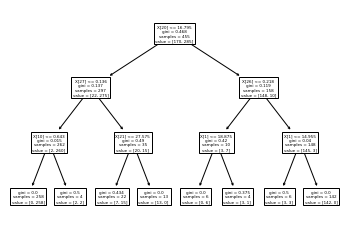

In [10]:
sp, cart = [], []
sp_depth = []
for i in tqdm(range(50)):
    sleep(3)
    #Spambase
    #data = pd.read_csv("datasets/spambase.csv")
    #X = data.to_numpy()
    #y = X[:, -1].astype(int)
    #X = X[:, 0:-1]
    
    #Banknote
    #X = np.load("datasets/banknote_train.npy")
    #y = np.load("datasets/banknote_label.npy")
    
    
    #Cancer
    data = load_breast_cancer()
    X = data.data
    y = data.target
    
    #X = X[y!=2]
    #y = y[y!=2]
    
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = i)
    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)
    #X_test = scaler.fit_transform(X_test)
    
    #CART
    clf = tree.DecisionTreeClassifier(max_depth=3, random_state=i, min_samples_leaf = 4)
    clf = clf.fit(X, y)
    
    #CART TAO
    cart_tree = ClassificationTree()
    cart_tree.initialize_from_CART(X, y, clf)
    tao = TAO(cart_tree)
    tao.evolve(X, y)
    preds = cart_tree.predict_data(X_test, cart_tree.tree[0])
    cart_score = cart_tree.score(preds, y_test)
    tree.plot_tree(clf)  
    #c_score = clf.score(X_test, y_test)
    #print(c_score)
    #print("CART test: ", c_score)
    cart.append(cart_score)
    
    #Sparse
    root = train_tree(X, y, n_splits = 7, min_points_leaf = 3)
    sparse_tree = ClassificationTree()
    sp_depth.append(sparse_tree.get_depth(root))
    sparse_tree.initialize(X, y, root)
    tao = TAO(sparse_tree)
    tao.evolve(X, y)
    sparse_tree.print_tree_structure()
    preds = sparse_tree.predict_data(X_test, root)
    sparse_score = sparse_tree.score(preds, y_test)
    #print(sparse_score)
    #print("Sparse minimal test: ", sparse_score)
    sp.append(sparse_score)
    

print("CART: %s +- %s Sparse: %s +- %s Mean_depth: %s" % (np.mean(cart), np.std(cart), np.mean(sp), np.std(sp), np.mean(sp_depth)))